In [196]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior, beta_tuning_param_function)
import multiprocessing
from typing import Dict, Tuple, Optional, List

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [197]:
# Set up prior distribution
prior_dict = {'EI_gscale': {'bounds': (-3, 3), 'rescale_function': log_scale_forward},
              'EE_gscale': {'bounds': (-3, 0), 'rescale_function': log_scale_forward},
              'II_gscale': {'bounds': (-3, 3), 'rescale_function': log_scale_forward},
              'IE_gscale': {'bounds': (-3, 3), 'rescale_function': log_scale_forward},
              'EI_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'EE_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'II_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'IE_prob': {'bounds': (0.5, 1), 'rescale_function': linear_scale_forward},
              'L2e_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L2i_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5e_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5i_distal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L2e_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L2i_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5e_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              'L5i_proximal': {'bounds': (-4, -1), 'rescale_function': log_scale_forward},
              }


prior = UniformPrior(parameters=list(prior_dict.keys()))
dt = 0.5

In [302]:
dataset_type = 'suprathreshold'
dataset_indices = [84]

model_architecture = {'L5_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L2_pyramidal': {'hidden_dim': 64, 'n_layers': 5},
                      'L5_basket': {'hidden_dim': 8, 'n_layers': 2},
                      'L2_basket': {'hidden_dim': 8, 'n_layers': 2}}

model_dict, dataset_dict = dict(), dict()
for cell_type in ['L5_pyramidal']:
    cell_type_dataset = torch.utils.data.ConcatDataset(
        [torch.load(f'datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    model_dict[cell_type] = utils.model_celltype_lstm(
        input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type])
    # model_dict[cell_type] = torch.jit.script(utils.model_celltype_lstm(
    #     input_size=input_size, output_size=output_size, device=device, **model_architecture[cell_type]))
    model_dict[cell_type].load_state_dict(torch.load(f'{dataset_type}_models/{cell_type}_{dataset_type}_model.pt'))
    model_dict[cell_type].to(device)

In [303]:
model = model_dict['L5_pyramidal']
validation_data = dataset_dict['L5_pyramidal'].datasets[0]

In [304]:
def run_model(model, validation_set):
    val_data = validation_set[:][0][:,:,:].float().to(device)
    with torch.no_grad():
        model.eval()
        output_sequence = []
        h0 = torch.zeros(model.n_layers, 63, model.hidden_dim).to(device)
        c0 = torch.zeros(model.n_layers, 63, model.hidden_dim).to(device)
        for t in range(model.kernel_size, val_data.size(1)):
            output, h0, c0 = model(val_data[:,(t-model.kernel_size):t, :], h0, c0)
            output_sequence.append(output)

        output_sequence = torch.cat(output_sequence, dim=1)

    return output_sequence


In [305]:
pred = run_model(model, validation_data)

(-5.0, 205.0)

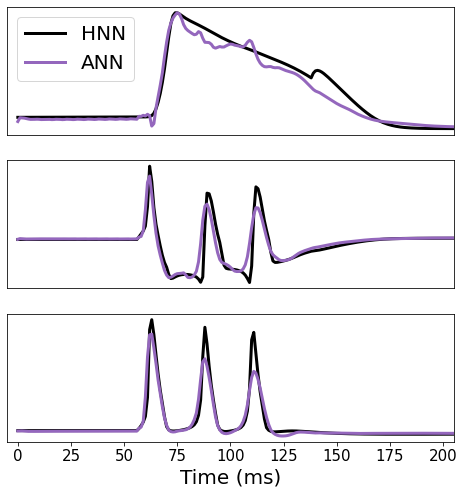

In [343]:
# cell_idx = 4
cell_idx = 22

hnn_color = 'k'
ann_color = 'C4'

plot_xlim = (-5,205)
linewidth = 3

plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
sec_idx = 3
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.xlim(plot_xlim)

plt.legend(fontsize=20)

plt.subplot(3,1,2)
sec_idx = 9
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.xlim(plot_xlim)


plt.subplot(3,1,3)
sec_idx = 8
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks(size=15)
plt.yticks([])
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(plot_xlim)

plt.savefig('single_cell_prediction.svg')


In [255]:
validation_data.vsec_names

['apical_trunk',
 'apical_1',
 'apical_2',
 'apical_tuft',
 'apical_oblique',
 'basal_1',
 'basal_2',
 'basal_3',
 'soma',
 'dipole']